Random Projection vs PCA

Begin importing dataset and understanding number of classes/features

In [6]:
from sklearn.datasets import fetch_rcv1
from sklearn.model_selection import train_test_split

rcv1 = fetch_rcv1(shuffle=True, random_state=0)
print(f"Data shape: {rcv1.data.shape}")

X, Y = rcv1.data, rcv1.target      # X: (n_samples, n_features), Y: multilabel CSR
names = rcv1.target_names

Data shape: (804414, 47236)


Create a subset for visualization

In [8]:
import numpy as np
SUBSET_SIZE = 1000
rng = np.random.default_rng(42)
idx = rng.choice(X.shape[0], size=SUBSET_SIZE, replace=False)
X_sub = X[idx]
Y_sub = Y[idx]

label_counts = np.asarray(Y_sub.sum(axis=1)).ravel()
single_mask = label_counts == 1
X_vis = X_sub[single_mask]
Y_vis = Y_sub[single_mask]

# Get class id for each remaining sample
row_idx, col_idx = Y_vis.nonzero()
labels = np.full(Y_vis.shape[0], -1, dtype=int)
labels[row_idx] = col_idx

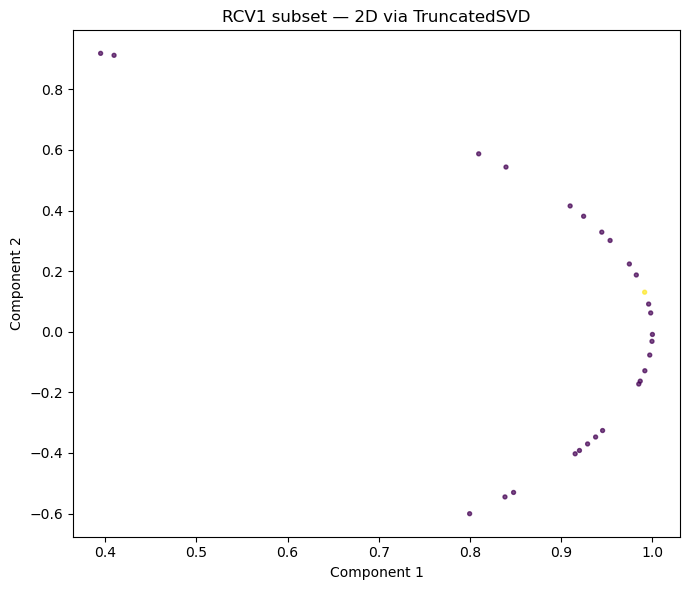

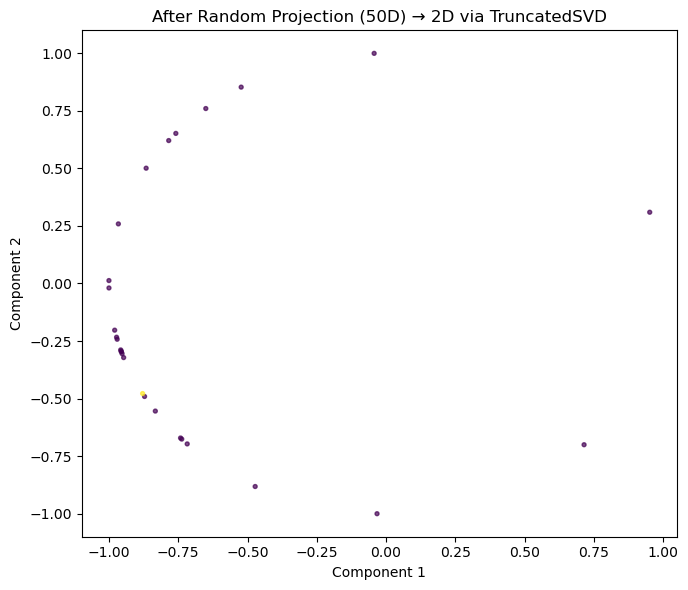

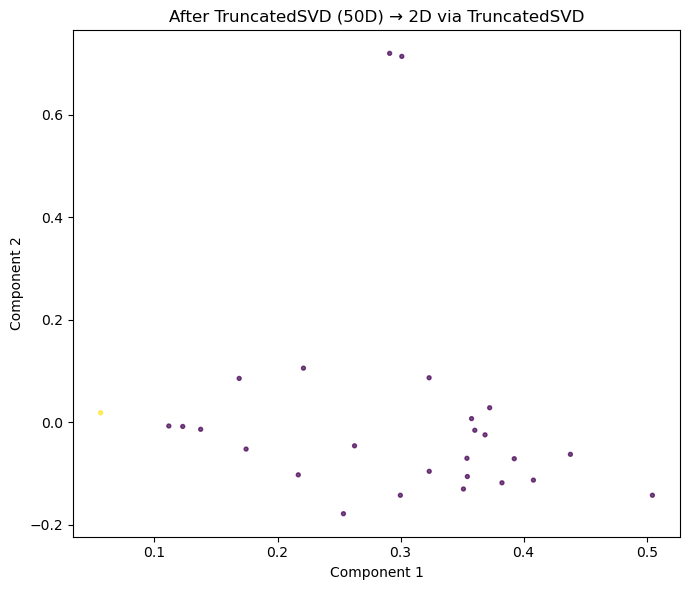

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.random_projection import SparseRandomProjection

def lsa_embed(X, d, seed=0):
    svd = TruncatedSVD(n_components=d, random_state=seed)
    Z = svd.fit_transform(X)
    Z = Normalizer(copy=False).fit_transform(Z)  # classic LSA: L2-normalize
    return Z, svd

def plot2d(Z, labels, title):
    plt.figure(figsize=(7,6))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=8, alpha=0.7)  # use default colors
    plt.title(title)
    plt.xlabel("Component 1"); plt.ylabel("Component 2")
    plt.tight_layout(); plt.show()

# A) "Original": 2D SVD
Z_orig2, svd2 = lsa_embed(X_vis, 2, seed=0)
plot2d(Z_orig2, labels, "RCV1 subset — 2D via TruncatedSVD")

# B) Random Projection (50D) -> 2D SVD
RP_D = 50
rp = SparseRandomProjection(n_components=RP_D, random_state=0)
X_rp = rp.fit_transform(X_vis)       # may be sparse or dense depending on params
Z_rp2, _ = lsa_embed(X_rp, 2, seed=0)
plot2d(Z_rp2, labels, "After Random Projection (50D) → 2D via TruncatedSVD")

# C) PCA analogue: SVD (50D) -> 2D SVD
PCA_D = 50
Z_pca50, svd50 = lsa_embed(X_vis, PCA_D, seed=0)
svd_to2 = TruncatedSVD(n_components=2, random_state=0)
Z_pca2 = svd_to2.fit_transform(Z_pca50)
plot2d(Z_pca2, labels, "After TruncatedSVD (50D) → 2D via TruncatedSVD")

ValueError: x and y must have same first dimension, but have shapes (200,) and (27,)

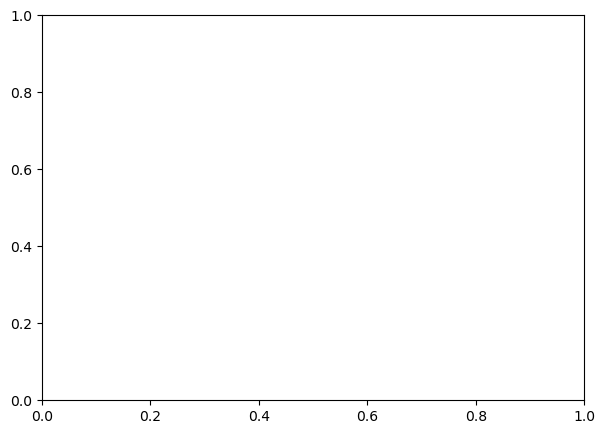

In [10]:
MAX_K = 200
svd_full = TruncatedSVD(n_components=MAX_K, random_state=0)
_ = svd_full.fit_transform(X_vis)  # we only need explained_variance_ratio_
cum = np.cumsum(svd_full.explained_variance_ratio_)

plt.figure(figsize=(7,5))
plt.plot(np.arange(1, MAX_K+1), cum, marker='o', linewidth=1)
plt.xlabel("Number of components (k)")
plt.ylabel("Cumulative explained variance ratio")
plt.title("TruncatedSVD Scree Curve (RCV1 subset)")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout(); plt.show()

print("First 10 EV ratios:", svd_full.explained_variance_ratio_[:10])
print("Cumulative EV @ k=50:", float(cum[49]) if MAX_K>=50 else None)
print("Cumulative EV @ k=100:", float(cum[99]) if MAX_K>=100 else None)